# Loads packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.optim as optim
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import sys,os
sys.path.append(os.path.realpath('./src/'))
import pandas as pd
from materialEncoder import MaterialEncoder
import time
import itertools

## Loads the Database

In [2]:
def preprocessData():
  df = pd.read_excel('./data/MaterialDatabase_FULL.xlsx')# # 
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = torch.tensor((df[df.columns[3:]].to_numpy())).float()

  return dataIdentifier, trainInfo, df
dataIdentifier, trainInfo, df = preprocessData()

props = df.columns[3:].tolist()
nmat, nprop = trainInfo.size()

## Loads the truss

In [3]:
from examples import getExample
from trussFE import TrussFE

#Loads the example truss
exampleName, nodeXY, connectivity, bc = getExample(4)
#Changes the force
bc['forces'] = {'nodes':np.array([2]), 'fx':1.E3*torch.tensor([0.]), 'fy':1.E2*torch.tensor([125.])}

#Loads the truss in truss
truss = TrussFE(nodeXY, connectivity, bc)

## SELECT CONSTRAINTS AND OBJECTIVES HERE

In [4]:
#Defines constraints and objectives
constraints = {'massCons': {'isOn':False, 'maxMass':5}, \
               'costCons': {'isOn':False, 'maxCost':5},\
               'tensionCons': {'isOn':True, 'FOS':4.},\
               'complianceCons': {'isOn':False, 'maxJ':35},\
               'compressionCons': {'isOn':True, 'FOS':4.},\
               'co2Cons': {'isOn':False, 'maxco2':30},\
               'energyCons': {'isOn':False, 'maxenergy' : 1e10},\
               'waterCons': {'isOn':False, 'maxwater':4e3}}


objectives = {'cost': {'isOn':False},\
              'mass': {'isOn':True}, \
              'co2': {'isOn':False},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': True}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Three or more entries have isOn=True')

## ---------------------------------------------------------------------------------------

## Defines problem

In [5]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.termination.default import DefaultMultiObjectiveTermination

class MixedVarsZDT1(ElementwiseProblem):

    def __init__(self, truss, trainInfo , constraints, objectives, nc, no, nmat, **kwargs):

        variables = dict()

        variables[f"x01"] = Integer(bounds=(0, nmat-1))

        for k in range(2, 8):
            variables[f"x{k:02}"] = Real(bounds=(2e-6, 2e-2))

        super().__init__(vars=variables, n_obj=no, n_ieq_constr=nc, **kwargs)
        
        self.truss=truss
        self.trainInfo=trainInfo
        self.constraints=constraints
        self.objectives=objectives
        
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array([x[f"x{k:02}"] for k in range(1, 8)])
        
        matprop=trainInfo[int(x[0]),:]  
        
        x_tensor = torch.from_numpy(x[1:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 
        
        
        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)
        
  
problem = MixedVarsZDT1(truss,trainInfo , constraints, objectives, nc, no, nmat)

    
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

algorithm = NSGA2(pop_size=100,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )

termination=('n_gen', 150)

## Runs the solver

In [6]:
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
print('Solver time : {:.2F}'.format(time.perf_counter() - start))

C:\Users\luisy\Desktop\CODES\src\trussFE.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  Kasm = torch.sparse_coo_tensor(self.nodeIdx, sK,\


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     20 |  0.000000E+00 |  1.6198471472 |             - |             -
     2 |      200 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0108765058 |         ideal
     3 |      300 |     17 |  0.000000E+00 |  0.000000E+00 |  0.6729730265 |         nadir
     4 |      400 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0119880464 |         ideal
     5 |      500 |     31 |  0.000000E+00 |  0.000000E+00 |  0.0146102755 |         ideal
     6 |      600 |     32 |  0.000000E+00 |  0.000000E+00 |  3.009770E+01 |         nadir
     7 |      700 |     33 |  0.000000E+00 |  0.000000E+00 |  0.0070063200 |         nadir
     8 |      800 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0070753083 |             f
     9 |      900 |     51 |  0.000000E+00 |  0.000000E+00 |  0.0058071514 |             f
    10 |     1000 |     55 |  0.000000E+00 |  0.000000E+00 |  0.0024905797 |             f

    89 |     8900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0076733848 |         ideal
    90 |     9000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0006548575 |             f
    91 |     9100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0011664876 |             f
    92 |     9200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0017238501 |             f
    93 |     9300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0089394392 |         nadir
    94 |     9400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0009534025 |             f
    95 |     9500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0030675153 |         nadir
    96 |     9600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0010428982 |             f
    97 |     9700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014563497 |             f
    98 |     9800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0021813568 |             f
    99 |     9900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0029242535 |             f

## Plots the result

Solution limited by the areas


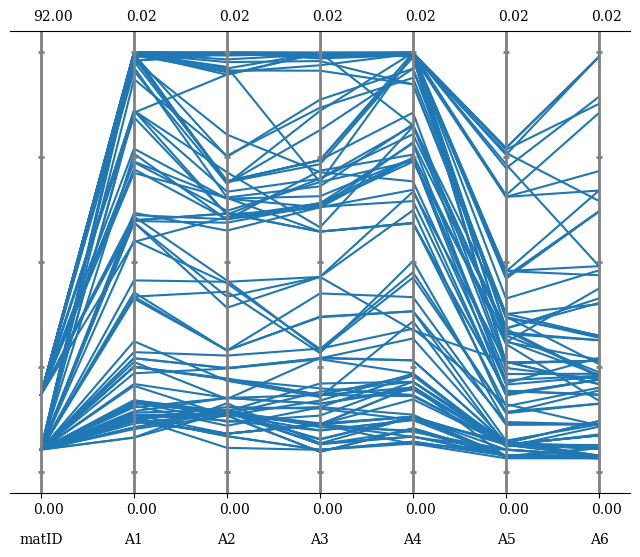

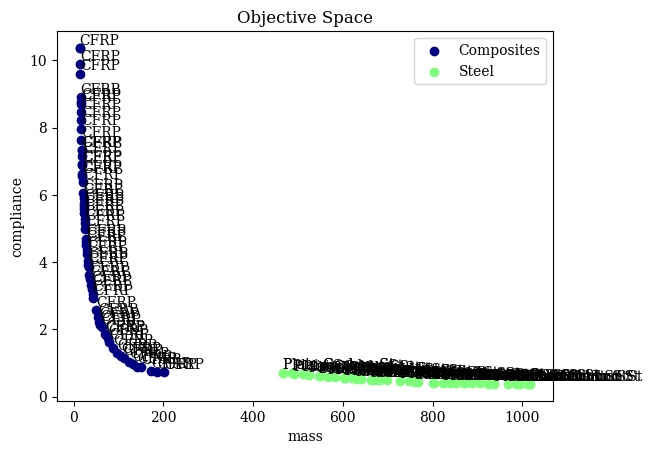

In [7]:
from pymoo.visualization.pcp import PCP
X = res.X
F = res.F
G = res.G
Z_res = [[d['x01']] for d in X]



labels = list(res.opt[0].X.keys())
labels_x = ['matID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6']
bounds = np.array([problem.vars[name].bounds for name in labels]).T


X = np.array([[sol.X[name] for name in labels] for sol in res.opt])

plot1 = PCP(labels=labels_x, bounds=bounds)
plot1.set_axis_style(color="grey", alpha=1)
plot1.add(X)

plot1.show()
plt.savefig('./figures/PCP.png',bbox_inches='tight', dpi = 200)


# Maybe the solution is limited by the limits in areas. Example, you want to minimize the compliance but
# you have a maximum area, so you can't reduce the compliance further

upper_bounds = bounds[1, 1:]*0.999
lower_bounds = bounds[0, 1:]*1.001



# Check if each row of X is within the limits
is_within_limits = np.logical_and(np.all(X[:,1:] >= lower_bounds, axis=1), np.all(X[:,1:] <= upper_bounds, axis=1))

# Print the results
if np.all(is_within_limits):
    print("Solution not limited by the areas")
else:
    print("Solution limited by the areas")



names = []
types = []

fig, ax = plt.subplots()
legend_dict = {}

for xData in Z_res:
    matname = dataIdentifier['name'][int(xData[0])]
    mattype = dataIdentifier['className'][int(xData[0])]
    names.append(matname)
    types.append(mattype)
    
unique_labels = list(set(types))

mat_colors = {}
for i, mattype in enumerate(types):
    if mattype not in mat_colors:
        mat_colors[mattype] = plt.cm.get_cmap('jet')(i / len(set(types)))

# add scatter plot for each unique label
for i, (x, y) in enumerate(F):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)


# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")


# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures/Integer.png',bbox_inches='tight', dpi = 200)
plt.show()

## Plots the result with zoom

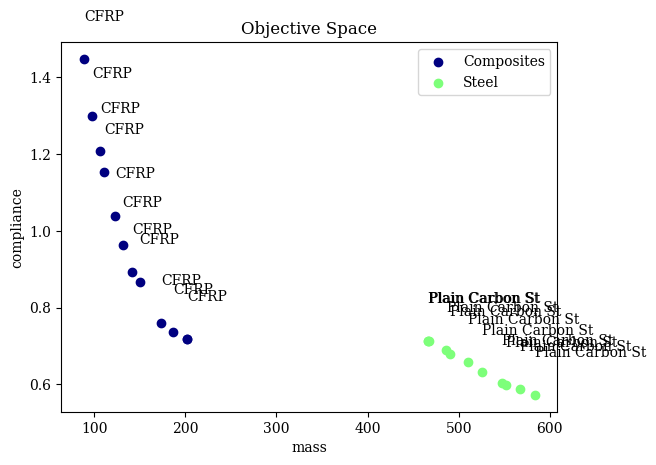

In [8]:
# If you want to zoom a part of the plot
xinf=80
xsup=600
yinf=0
ysup=1.6



names = []
types = []

fig, ax = plt.subplots()
legend_dict = {}

for xData in Z_res:
    matname = dataIdentifier['name'][int(xData[0])]
    mattype = dataIdentifier['className'][int(xData[0])]
    names.append(matname)
    types.append(mattype)
    
unique_labels = list(set(types))

mat_colors = {}
for i, mattype in enumerate(types):
    if mattype not in mat_colors:
        mat_colors[mattype] = plt.cm.get_cmap('jet')(i / len(set(types)))

# add scatter plot for each unique label
for i, (x, y) in enumerate(F):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    if (xinf<= x <= xsup) & (yinf <= y<= ysup):
        ax.scatter(x, y, color=color, label=label)
        ax.text(x + 0.1, y + 0.1, material)
        if mattype not in legend_dict:
            legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)

# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")

# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.show()



